In [2]:
import math, random, time, numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

SEED = 1337
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE


device(type='cpu')

## 2. Moons Dataset & Regularization [3 marks]

Generate Make-Moons dataset without using `sklearn.make_moons`. Use default noise **0.2**, also create two extra test sets with noise **0.1** and **0.3** for robustness reporting. Make training set and test set with **500 points** each. Standardize $x$ after the split using train statistics only. Create a validation split of the train set with **20 percent** for model selection. Use random seed **1337**.

### function `custom_make_moons`

* **Purpose:** Generate the two-class “moons” dataset *without* using sklearns helper.
* **How it builds the moons:**
    * Creates two 2-D arcs parameterized by an angle
  $$
  \text{t} = (0, π)
  $$
    * Upper moon points are ($\cos(t)$, $\sin(t)$).
    * Lower moon is a mirrored/shifted version $(1 - \cos t, - \sin t - 0.5)$ so the two arcs interleave.
* **Labels:** First half of the points are labeled class 0 (upper moon), second half class 1 (lower moon).
* **Noise:** Adds isotropic Gaussian noise with standard deviation `noise` to every point to control difficulty.
* **Reproducibility:** Uses a fixed random seed to make the same dataset each time.
* **Outputs:**
    * $\mathbf{X}$: an $(n_\text{samples}, 2)$ array of 2-D coordinates (`float32`).
    * $\mathbf{y}$: an $(n_{\text{samples}},)$ vector of integer class labels 0/1 (`int64`).
    
### function `train_val_split`

* **Purpose:** Split a dataset into training and validation subsets randomly.
* **How it works:**
    * Shuffles indices using a given seed.
    * Takes the first `val_frac` portion as validation, the rest as training.
* **Why:** Ensures train and validation come from the same distribution and retain (on average) class balance.



## Creating Train/Test and Robustness Sets

* **Main pool (noise = 0.2):** One dataset is generated, then (in your current code) the first 500 samples are used for training and the last 500 for testing.
* **Issue:** Without shuffling, this yields near single-class splits due to the stacking order.
* **Fix (conceptual):** Shuffle the pooled data before slicing, or generate train and test with different seeds.
* **Robust test sets:** Two additional, independent datasets are created with `noise 0.1` and `0.3`.
* **Why:** They measure robustness, how well a model trained at `noise 0.2` generalizes when the noise level changes.


## Standardization (Scaling)

* **What:** Fit a `StandardScaler` (per-feature mean 0, variance 1) **only on the training split** and apply it to validation and all test sets.
* **Why:**
    * **Prevents data leakage** (test statistics must not influence training).
    * **Helps optimization** (features on similar scales make gradient-based training more stable).
* **Result:** You get standardized versions of train/val/test that share the same transformation learned from training data.


## DataLoaders (Turning Arrays into Mini-batches)

* **What:** Wrap each `(X, y)` pair into a PyTorch `TensorDataset` and create a `DataLoader`.
* **Why:**
    * Provides **mini-batches** for efficient GPU/CPU training.
    * Controls **shuffling** (enabled for training to reduce variance across epochs; disabled for evaluation for determinism).
    * Ensures **dtypes** match model expectations: features as `float32`, labels as `int64`.

In [3]:
def custom_make_moons(n_samples=1000, noise=0.2, random_state=1337):
    rng = np.random.RandomState(random_state)
    n1 = n_samples // 2
    n2 = n_samples - n1

    t1 = np.linspace(0, math.pi, n1)
    x1 = np.c_[np.cos(t1), np.sin(t1)]
    t2 = np.linspace(0, math.pi, n2)
    x2 = np.c_[1 - np.cos(t2), -np.sin(t2) - 0.5]  # shift down a bit

    X = np.vstack([x1, x2]).astype(np.float32)
    y = np.hstack([np.zeros(n1, dtype=np.int64), np.ones(n2, dtype=np.int64)])

    if noise and noise > 0:
        X += rng.normal(scale=noise, size=X.shape).astype(np.float32)

    return X, y

def train_val_split(X, y, val_frac=0.2, random_state=SEED):
    rng = np.random.RandomState(random_state)
    n = len(X)
    idx = np.arange(n); rng.shuffle(idx)
    n_val = int(n * val_frac)
    val_idx, tr_idx = idx[:n_val], idx[n_val:]
    return X[tr_idx], y[tr_idx], X[val_idx], y[val_idx]

X_all, y_all = custom_make_moons(n_samples=1000, noise=0.2, random_state=SEED)
X_train, y_train = X_all[:500], y_all[:500]
X_test_main, y_test_main = X_all[500:], y_all[500:]

X_test_n01, y_test_n01 = custom_make_moons(n_samples=500, noise=0.1, random_state=SEED+1)
X_test_n03, y_test_n03 = custom_make_moons(n_samples=500, noise=0.3, random_state=SEED+2)
X_test_n04, y_test_n04 = custom_make_moons(n_samples=500, noise=0.4, random_state=SEED+3)


X_tr, y_tr, X_val, y_val = train_val_split(X_train, y_train, val_frac=0.2, random_state=SEED)


scaler = StandardScaler().fit(X_tr)
X_tr_s   = scaler.transform(X_tr)
X_val_s  = scaler.transform(X_val)
X_test_s = scaler.transform(X_test_main)
X_n01_s  = scaler.transform(X_test_n01)
X_n03_s  = scaler.transform(X_test_n03)
X_n04_s  = scaler.transform(X_test_n04)

def to_loader(X, y, batch_size=64, shuffle=True):
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).long())
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)

BATCH = 64
tr_loader   = to_loader(X_tr_s,  y_tr,  BATCH, True)
val_loader  = to_loader(X_val_s, y_val, BATCH, False)
test_loader = to_loader(X_test_s, y_test_main, BATCH, False)
n01_loader  = to_loader(X_n01_s, y_test_n01,  BATCH, False)
n03_loader  = to_loader(X_n03_s, y_test_n03,  BATCH, False)
n04_loader  = to_loader(X_n04_s, y_test_n04,  BATCH, False)
X_tr_s.shape, X_val_s.shape, X_test_s.shape


((400, 2), (100, 2), (500, 2))

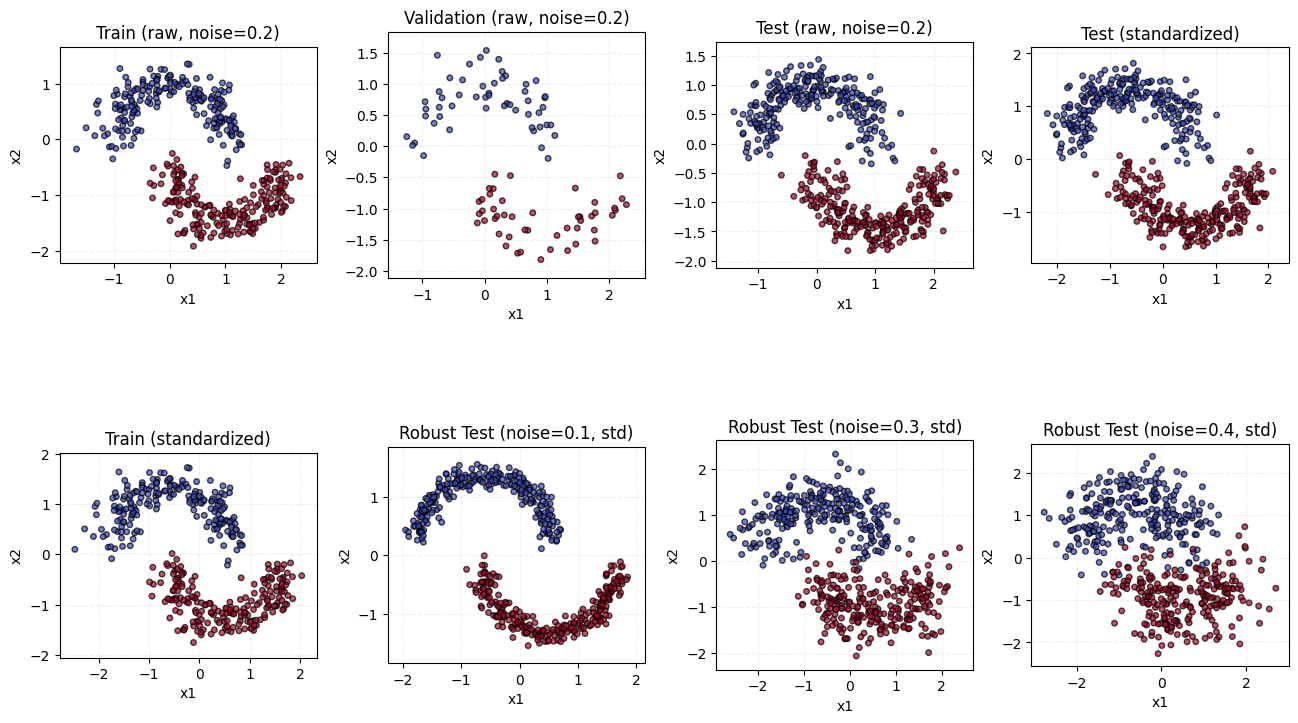

In [33]:

import matplotlib.pyplot as plt
import numpy as np

def scatter_xy(ax, X, y, title="", alpha=0.7, s=16):
    ax.scatter(X[:,0], X[:,1], c=y, cmap="coolwarm", edgecolor="k", s=s, alpha=alpha)
    ax.set_title(title)
    ax.set_xlabel("x1"); ax.set_ylabel("x2")
    ax.set_aspect("equal", adjustable="box")
    pad = 0.3
    xmin, xmax = X[:,0].min()-pad, X[:,0].max()+pad
    ymin, ymax = X[:,1].min()-pad, X[:,1].max()+pad
    ax.set_xlim(xmin, xmax); ax.set_ylim(ymin, ymax)
    ax.grid(True, ls="--", alpha=0.2)

fig, axes = plt.subplots(2, 4, figsize=(13, 8), constrained_layout=True)


scatter_xy(axes[0,0], X_tr,        y_tr,        "Train (raw, noise=0.2)")
scatter_xy(axes[0,1], X_val,       y_val,       "Validation (raw, noise=0.2)")
scatter_xy(axes[0,2], X_test_main, y_test_main, "Test (raw, noise=0.2)")
scatter_xy(axes[0,3], X_test_s,    y_test_main, "Test (standardized)")


scatter_xy(axes[1,0], X_tr_s,   y_tr,        "Train (standardized)")
scatter_xy(axes[1,1], X_n01_s,  y_test_n01,  "Robust Test (noise=0.1, std)")
scatter_xy(axes[1,2], X_n03_s,  y_test_n03,  "Robust Test (noise=0.3, std)")
scatter_xy(axes[1,3], X_n04_s,  y_test_n04,  "Robust Test (noise=0.4, std)")

plt.show()


# **Training Functions with baseline , L1 and L2**

* **Model:** a 1-hidden-layer MLP: 2-D input $\rightarrow$ `hidden` ReLU units $\rightarrow$ **one logit** (binary classification).

* **Loss:** `BCEWithLogitsLoss` (numerically stable: combines sigmoid + binary cross-entropy in one op).

* **Optimizer:** **Adam** with learning rate `lr` (adaptive steps; good default for small MLPs).

* **Training loop (per epoch):**
    1. Iterate mini-batches from `tr_loader`.
    2. Forward pass $\rightarrow$ logits; compute loss.
    3. Backprop (`backward`) and optimizer `step`.
    4. Evaluate on `val_loader` to get **validation AUROC** (and loss).

* **Early stopping:** `EarlyStopper(patience, mode="max")` tracks the **best validation AUROC**; if it doesn't improve for `patience` epochs, stop and **restore the best weights**.
    * *Why AUROC?* It's threshold-free and robust to mild class imbalance. (Ensure validation has both classes.)

**Return value:** the **best-checkpoint model** (by val AUROC) and a small dict of validation metrics, e.g. `{'auroc': ..., 'loss': ...}`.

In [5]:
from sklearn.exceptions import UndefinedMetricWarning
import warnings

class MLP1H(nn.Module):
    def __init__(self, d_in=2, d_h=32):
        super().__init__()
        self.fc1 = nn.Linear(d_in, d_h)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(d_h, 1)  # logit
    def forward(self, x):
        x = self.act(self.fc1(x))
        return self.fc2(x).squeeze(1)  # (N,)

def auroc_from_logits(logits, y_true):
    with torch.no_grad():
        probs = torch.sigmoid(logits).detach().cpu().numpy()
        y = y_true.detach().cpu().numpy()
        try:
            return roc_auc_score(y, probs)
        except ValueError:
            return float("nan")  # or 0.5

@torch.no_grad()
def evaluate(model, loader, criterion=None):
    model.eval()
    all_logits, all_y = [], []
    total_loss = 0.0; n = 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        all_logits.append(logits)
        all_y.append(yb)
        if criterion is not None:
            loss = criterion(logits, yb.float())
            total_loss += loss.item() * len(xb); n += len(xb)
    logits = torch.cat(all_logits); y = torch.cat(all_y)
    auroc = auroc_from_logits(logits, y)
    loss = (total_loss / n) if n > 0 else None
    return {"auroc": auroc, "loss": loss}

class EarlyStopper:
    def __init__(self, patience=50, mode="max"):
        self.patience = patience
        self.mode = mode
        self.best = -np.inf if mode=="max" else np.inf
        self.count = 0
        self.best_state = None
        self.best_epoch = -1

    def step(self, metric, model, epoch=None):
        improved = (metric > self.best) if self.mode=="max" else (metric < self.best)
        if improved:
            self.best = metric
            self.count = 0
            self.best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            if epoch is not None: self.best_epoch = epoch
        else:
            self.count += 1
        return self.count >= self.patience

    def restore_best(self, model):
        if self.best_state is not None:
            model.load_state_dict(self.best_state)

def layer_sparsity(module, tol=1e-6, include_bias=False):
    stats = []
    for name, layer in module.named_modules():
        if isinstance(layer, nn.Linear):
            W = layer.weight.detach().cpu().numpy()
            zf_w = (np.abs(W) < tol).mean()
            if include_bias and layer.bias is not None:
                b = layer.bias.detach().cpu().numpy()
                zf_b = (np.abs(b) < tol).mean()
                stats.append((name, zf_w, zf_b))
            else:
                stats.append((name, zf_w))
    return stats


### **function** `train_baseline(hidden, epochs, patience, lr)`

**What it is:** plain training with **no explicit regularization** beyond early stopping.

**When to use:** as a reference model to compare against L1/L2; useful to see if the network tends to overfit (e.g., great train performance but weaker validation/test).

**Typical behavior:** can fit the moons well; decision boundary may be a bit "wiggly" at higher noise.




### **function** `train_with_l1(lam, hidden, epochs, patience, lr)`

**What's added:** **L1 penalty** on **weights** of all Linear layers (biases excluded).

Loss becomes:
$$\text{BCEWithLogits} + \lambda \sum_{\text{layers}} \|W\|_1, \qquad \|W\|_1 = \sum |W_{ij}|$$

**Reason:**
* **Exclude biases:** common practice; we want to sparsify **connections/features**, not shift thresholds.
* **Effect:** encourages **sparsity** (many weights driven near/at zero). This can simplify the model and sometimes improve generalization; too large $\lambda$ can underfit.

**Final Parameter:** final val AUROC; optionally **sparsity per layer** (fraction of ~zero weights) to demonstrate L1's effect.


### **function** `train_with_l2(weight_decay, hidden, epochs, patience, lr)`

**What's added:** **L2 regularization** via the optimizer's `weight_decay` (Adam's decoupled weight decay $\approx$ AdamW style).

**How it works:** on each step, parameters are smoothly shrunk toward zero proportional to `weight_decay` (independently of the gradient term).

**Effect vs L1:**
* L2 produces **smooth shrinkage** (fewer extreme weights), typically yielding **smoother decision boundaries** and better robustness.
* Unlike L1, L2 generally does **not** make weights exactly zero (so, less sparsity, more smoothness).

**What to report:** best `weight_decay` chosen by validation **AUROC**, and the resulting test AUROC(s).


### **Hyperparameters (how to justify them briefly)**

* `hidden=32`: enough capacity for non-linear boundaries on 2-D moons without being excessive.
* `epochs=2000` & `patience=50`: allow long training but rely on early stopping to halt when validation AUROC plateaus.
* `lr=1e-2`: a solid default for Adam on small MLPs.
* `lam` / `weight_decay`: tune via validation AUROC; L1 controls **sparsity strength**, L2 controls **shrinkage strength**.

In [6]:
BCE = nn.BCEWithLogitsLoss()

def train_baseline(hidden=32, epochs=2000, patience=50, lr=1e-2):
    model = MLP1H(2, hidden).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    stopper = EarlyStopper(patience=patience, mode="max")

    for ep in range(epochs):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = BCE(logits, yb.float())
            opt.zero_grad(); loss.backward(); opt.step()

        val = evaluate(model, val_loader, BCE)
        if stopper.step(val["auroc"], model): break

    stopper.restore_best(model)
    return model, evaluate(model, val_loader, BCE)

def train_with_l1(lam, hidden=32, epochs=2000, patience=50, lr=1e-2):
    model = MLP1H(2, hidden).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    stopper = EarlyStopper(patience=patience, mode="max")

    with torch.no_grad():
        nW = sum(m.weight.numel() for m in model.modules() if isinstance(m, nn.Linear))

    for ep in range(epochs):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = BCE(logits, yb.float())

            l1 = 0.0
            for m in model.modules():
                if isinstance(m, nn.Linear):
                    l1 = l1 + m.weight.abs().sum()
            loss = loss + lam * (l1 / nW)

            opt.zero_grad(); loss.backward(); opt.step()

        val = evaluate(model, val_loader, BCE)
        if stopper.step(val["auroc"], model): break

    stopper.restore_best(model)
    return model, evaluate(model, val_loader, BCE)

def train_with_l2(weight_decay, hidden=32, epochs=2000, patience=50, lr=1e-2):
    model = MLP1H(2, hidden).to(DEVICE)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    stopper = EarlyStopper(patience=patience, mode="max")

    for ep in range(epochs):
        model.train()
        for xb, yb in tr_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = BCE(logits, yb.float())
            opt.zero_grad(); loss.backward(); opt.step()

        val = evaluate(model, val_loader, BCE)
        if stopper.step(val["auroc"], model): break

    stopper.restore_best(model)
    return model, evaluate(model, val_loader, BCE)


In [7]:
pool_X, pool_y = custom_make_moons(n_samples=1000, noise=0.2, random_state=SEED)

rng = np.random.RandomState(SEED)
idx = np.arange(len(pool_X))
rng.shuffle(idx)
pool_X, pool_y = pool_X[idx], pool_y[idx]


X_train, y_train = pool_X[:500], pool_y[:500]
X_test_main, y_test_main = pool_X[500:], pool_y[500:]

X_test_n01, y_test_n01 = custom_make_moons(n_samples=500, noise=0.1, random_state=SEED+1)
X_test_n03, y_test_n03 = custom_make_moons(n_samples=500, noise=0.3, random_state=SEED+2)
X_test_n04, y_test_n04 = custom_make_moons(n_samples=500, noise=0.4, random_state=SEED+3)


def train_val_split(X, y, val_frac=0.2, random_state=SEED):
    rng = np.random.RandomState(random_state)
    n = len(X)
    idx = np.arange(n); rng.shuffle(idx)
    n_val = int(n * val_frac)
    val_idx, tr_idx = idx[:n_val], idx[n_val:]
    return X[tr_idx], y[tr_idx], X[val_idx], y[val_idx]

X_tr, y_tr, X_val, y_val = train_val_split(X_train, y_train, val_frac=0.2, random_state=SEED)


scaler = StandardScaler().fit(X_tr)
X_tr_s   = scaler.transform(X_tr)
X_val_s  = scaler.transform(X_val)
X_test_s = scaler.transform(X_test_main)
X_n01_s  = scaler.transform(X_test_n01)
X_n03_s  = scaler.transform(X_test_n03)
X_n04_s  = scaler.transform(X_test_n04)

def to_loader(X, y, batch_size=64, shuffle=True):
    ds = TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).long())
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle, drop_last=False)

BATCH = 64
tr_loader   = to_loader(X_tr_s,  y_tr,  BATCH, True)
val_loader  = to_loader(X_val_s, y_val, BATCH, False)
test_loader = to_loader(X_test_s, y_test_main, BATCH, False)
n01_loader  = to_loader(X_n01_s, y_test_n01,  BATCH, False)
n03_loader  = to_loader(X_n03_s, y_test_n03,  BATCH, False)
n04_loader  = to_loader(X_n04_s, y_test_n04,  BATCH, False)

def counts(y):
    u, c = np.unique(y, return_counts=True); return dict(zip(u, c))
print("Train counts:", counts(y_tr))
print("Val counts  :", counts(y_val))
print("Test0.2     :", counts(y_test_main))
print("Test0.1     :", counts(y_test_n01))
print("Test0.3     :", counts(y_test_n03))
print("Test0.4     :", counts(y_test_n04))


Train counts: {np.int64(0): np.int64(201), np.int64(1): np.int64(199)}
Val counts  : {np.int64(0): np.int64(53), np.int64(1): np.int64(47)}
Test0.2     : {np.int64(0): np.int64(246), np.int64(1): np.int64(254)}
Test0.1     : {np.int64(0): np.int64(250), np.int64(1): np.int64(250)}
Test0.3     : {np.int64(0): np.int64(250), np.int64(1): np.int64(250)}
Test0.4     : {np.int64(0): np.int64(250), np.int64(1): np.int64(250)}


# **Train the following models:**

## 1. MLP with hidden layer - early stopping (patience=50)

`model_base, val_base = train_baseline(hidden=32, epochs=2000, patience=50, lr=1e-2)`

* **What it does:** Trains a one-hidden-layer MLP (32 ReLU units) for up to 2000 epochs using **Adam** (lr=0.01) and **early stopping**.
* **Early stopping (patience=50):** After each epoch we compute **validation AUROC**; if it doesn't improve for 50 epochs, we stop and **restore the best weights** seen so far.
* **What it returns:**
    * `model_base`: the trained model, **reset to the best validation AUROC checkpoint**.
    * `val_base`: a small metrics dict for that best checkpoint, e.g. `{'auroc': ..., 'loss': ...}`.

**Why AUROC for selection?** AUROC summarizes ranking quality across all thresholds and is robust to moderate class imbalance (provided both classes are present in validation).

In [8]:

model_base, val_base = train_baseline(hidden=32, epochs=2000, patience=50, lr=1e-2)
print("Validation (baseline):", val_base)

print("Test AUROCs:")
for name, loader in [("Main (noise=0.2)", test_loader),
                     ("Robust n=0.1", n01_loader),
                     ("Robust n=0.3", n03_loader), ("Robust n=0.4", n04_loader) ]:
    print(f"  {name:>15s}  AUROC={evaluate(model_base, loader, BCE)['auroc']:.3f}")

Validation (baseline): {'auroc': np.float64(1.0), 'loss': 0.04804174311459065}
Test AUROCs:
  Main (noise=0.2)  AUROC=0.999
     Robust n=0.1  AUROC=1.000
     Robust n=0.3  AUROC=0.999
     Robust n=0.4  AUROC=0.993


## 2.MLP with L1 regularization . L1 gird λ ∈ {1e−6, 3e−6, 1e−5, 3e−5, 1e−4, 3e−4}. Report layerwise sparsity and validation AUROC vs. λ

**a. Define a grid of L1 strengths**
`lam_grid = [1e-6, 3e-6, ..., 1e-1]`
This spans **very weak to very strong** L1 regularization (log-spaced).

**b. Train one model per $\lambda$ and collect metrics**
* `m, val = train_with_l1(lam=lam, ...)` trains an MLP with L1 penalty `lam` added to the loss.
* `models_l1[lam] = m` keeps the **best-checkpoint** model (by validation AUROC) for that $\lambda$.
* `val_aurocs.append(val["auroc"])` stores the **validation AUROC** at that best checkpoint.
* `sp = layer_sparsity(m, tol=1e-6)` measures **fraction of near-zero weights** per linear layer; saved to `sparsity_records`.

The `print(...)` line logs, for each $\lambda$:
* the $\lambda$ value,
* the **validation AUROC** (model-selection metric),
* the **sparsity** per layer (e.g., `[('fc1', 0.21), ('fc2', 0.08)]`).

**c. Plot AUROC vs $\lambda$ (log-x)**
The semilog plot shows how validation performance changes as you increase the L1 penalty. This curve often looks **inverted-U**:
* **Too small $\lambda$** $\rightarrow$ little regularization $\rightarrow$ possible **overfitting** (wavy boundary).
* **Sweet spot** $\rightarrow$ best generalization (peak AUROC).
* **Too large $\lambda$** $\rightarrow$ heavy shrinkage, many weights $\approx 0 \rightarrow$ **underfitting** (AUROC drops).

**d. Pick the best $\lambda$ by validation AUROC**
* `best_idx = argmax(val_aurocs)` and `best_lam = lam_grid[best_idx]`.
* `best_l1 = models_l1[best_lam]` fetches the actual trained model at that $\lambda$.

In [12]:
import numpy as np
import pandas as pd

l1_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]

def _pick(name_alt, name_base):
    g = globals()
    if name_alt in g: return g[name_alt]
    if name_base in g: return g[name_base]
    raise KeyError(f"Neither '{name_alt}' nor '{name_base}' found in globals().")

noise_loaders = {
    "0.1": _pick('n01_loader_alt', 'n01_loader'),
    "0.2": _pick('test_loader_alt','test_loader'),
    "0.3": _pick('n03_loader_alt', 'n03_loader'),
    "0.4": _pick('n04_loader_alt', 'n04_loader'),
}

if 'models_l1' not in globals() or not isinstance(models_l1, dict):
    models_l1 = {}

missing = [lam for lam in l1_grid if lam not in models_l1]
if missing:
    print(f"Training L1 models for missing λ: {missing}")
    for lam in missing:
        m, val = train_with_l1(lam, hidden=32, epochs=2000, patience=50, lr=1e-2)
        models_l1[lam] = m
        print(f"  λ={lam:.0e}  val_AUROC={val['auroc']:.3f}")
else:
    print("All L1 models present for l1_grid.")

def model_mean_sparsity(model, tol=1e-6):
    stats = layer_sparsity(model, tol=tol)
    zfs = []
    for tup in stats:
        if len(tup) == 2:
            _, zf_w = tup
            zfs.append(float(zf_w))
        elif len(tup) == 3:
            _, zf_w, zf_b = tup
            zfs += [float(zf_w), float(zf_b)]
    return float(np.mean(zfs)) if zfs else np.nan

sparsity_by_lambda = {lam: model_mean_sparsity(models_l1[lam]) for lam in l1_grid}

tables = {}
for nz, loader in noise_loaders.items():
    rows = []
    for lam in l1_grid:
        mdl = models_l1[lam]
        au = evaluate(mdl, loader, BCE)["auroc"]
        rows.append({"lambda": lam, "AUROC": float(au), "sparsity": float(sparsity_by_lambda[lam])})
    df = pd.DataFrame(rows)
    df["lambda"] = pd.Categorical(df["lambda"], categories=l1_grid, ordered=True)
    tables[nz] = df.sort_values("lambda").reset_index(drop=True)

for nz in ["0.1","0.2","0.3","0.4"]:
    print(f"\nAUROC & Sparsity (noise={nz})")
    print(tables[nz].to_string(index=False,
                               float_format=lambda v: f"{v:.6f}" if (isinstance(v,float) and v<1e-4) else f"{v:.3f}"))



Training L1 models for missing λ: [1e-06, 3e-06, 1e-05, 3e-05, 0.0001, 0.0003, 0.001]
  λ=1e-06  val_AUROC=1.000
  λ=3e-06  val_AUROC=1.000
  λ=1e-05  val_AUROC=1.000
  λ=3e-05  val_AUROC=1.000
  λ=1e-04  val_AUROC=1.000
  λ=3e-04  val_AUROC=1.000
  λ=1e-03  val_AUROC=1.000

AUROC & Sparsity (noise=0.1)
  lambda  AUROC  sparsity
0.000001  1.000  0.000000
0.000003  1.000  0.000000
0.000010  1.000  0.000000
0.000030  1.000  0.000000
   0.000  1.000  0.000000
   0.000  1.000  0.000000
   0.001  1.000  0.000000

AUROC & Sparsity (noise=0.2)
  lambda  AUROC  sparsity
0.000001  0.999  0.000000
0.000003  0.999  0.000000
0.000010  0.998  0.000000
0.000030  0.998  0.000000
   0.000  0.998  0.000000
   0.000  1.000  0.000000
   0.001  0.999  0.000000

AUROC & Sparsity (noise=0.3)
  lambda  AUROC  sparsity
0.000001  0.999  0.000000
0.000003  0.999  0.000000
0.000010  0.998  0.000000
0.000030  0.999  0.000000
   0.000  0.998  0.000000
   0.000  0.999  0.000000
   0.001  0.999  0.000000

AUROC & Sp

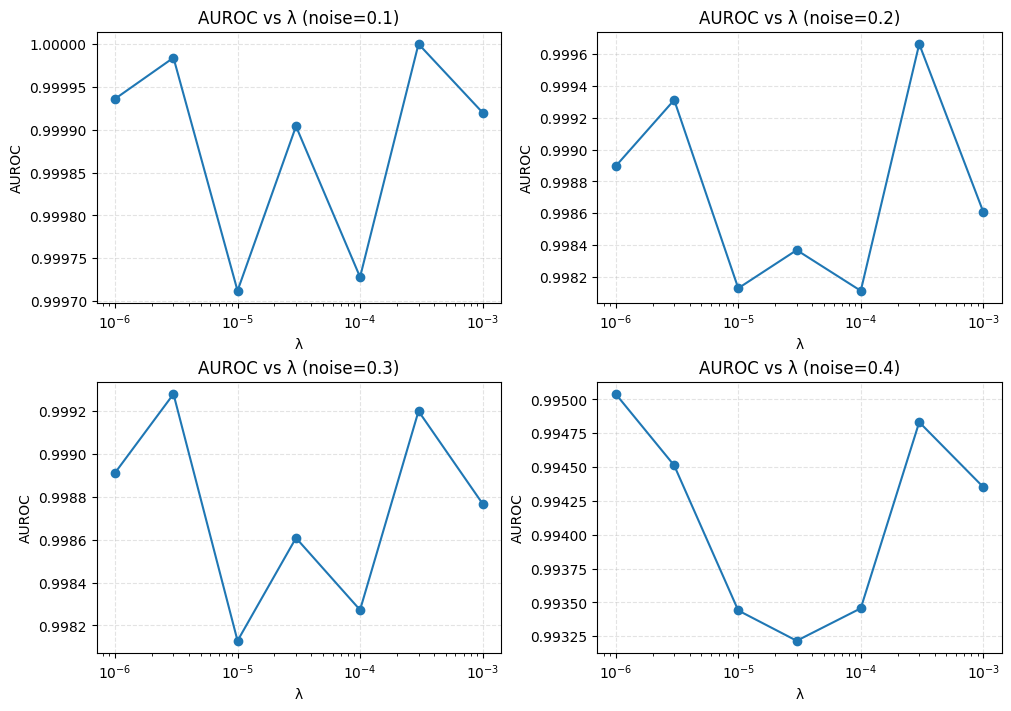

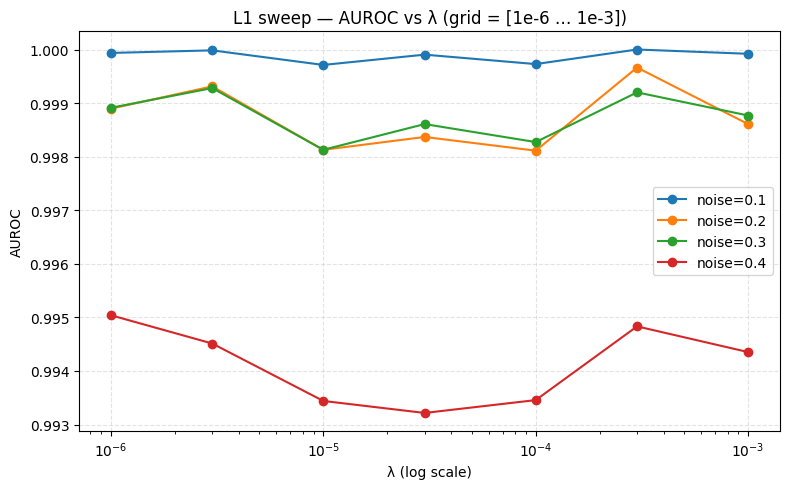

In [13]:
import matplotlib.pyplot as plt
import numpy as np

x = np.array(l1_grid, dtype=float)

fig, axes = plt.subplots(2, 2, figsize=(10, 7), constrained_layout=True)
axes = axes.ravel()
for i, nz in enumerate(["0.1","0.2","0.3","0.4"]):
    y = tables[nz]["AUROC"].values
    ax = axes[i]
    ax.semilogx(x, y, marker="o")
    ax.set_title(f"AUROC vs λ (noise={nz})")
    ax.set_xlabel("λ")
    ax.set_ylabel("AUROC")
    ax.grid(True, ls="--", alpha=0.35)
plt.show()

plt.figure(figsize=(8,5))
for nz in ["0.1","0.2","0.3","0.4"]:
    y = tables[nz]["AUROC"].values
    plt.semilogx(x, y, marker="o", label=f"noise={nz}")
plt.title("L1 sweep — AUROC vs λ (grid = [1e-6 … 1e-3])")
plt.xlabel("λ (log scale)")
plt.ylabel("AUROC")
plt.grid(True, ls="--", alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()


## 3. MLP with L2 regularization (you may vary the penalty coefficient by choose the best one using a validation dataset)

$wd \in \{1\text{e-}6, 3\text{e-}6, 1\text{e-}5, 3\text{e-}5, 1\text{e-}4, 3\text{e-}4, 1\text{e-}3\}$.
Report layerwise sparsity (near-zero fraction) and **validation AUROC vs. wd**.

**a. Define a grid of L2 strengths**
* `l2_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]`
This spans very weak $\rightarrow$ strong **weight decay** (log-spaced).

**b. Train one model per `wd` and collect metrics**
* `m, val = train_with_l2(weight_decay=wd, ...)` trains an MLP with **AdamW** (decoupled weight decay).
* `models_l2[wd] = m` keeps the **best-checkpoint** model (by **validation AUROC**) for that `wd`.
* `val_aurocs_l2.append(val["auroc"])` stores the validation AUROC at the best checkpoint.
* `sp = layer_sparsity(m, tol=1e-6)` measures **fraction of near-zero weights** per linear layer; we log/aggregate it (note: L2 shrinks weights toward zero, but doesn't drive exact zeros as aggressively as L1).

`print(...)` line logs, for each `wd`:
* the `wd` value,
* the **validation AUROC** (model-selection metric),
* the **sparsity** per layer (e.g., `[('fc1', 0.02), ('fc2', 0.00)]`).

**c. Plot AUROC vs `wd` (log-x)**
The semilog plot shows how validation performance changes as you increase weight decay. The curve often looks **inverted-U**:
* **Too small `wd`** $\rightarrow$ little shrinkage $\rightarrow$ possible **overfitting** (wiggly boundary).
* **Sweet spot** $\rightarrow$ best generalization (peak AUROC).
* **Too large `wd`** $\rightarrow$ heavy shrinkage $\rightarrow$ **underfitting** (AUROC drops).

**d. Pick the best `wd` by validation AUROC**
* `best_idx = argmax(val_aurocs_l2)` and `best_wd = l2_grid[best_idx]`.
* `best_l2 = models_l2[best_wd]` fetches the actual trained model at that weight decay.

In [15]:
import numpy as np
import pandas as pd

l2_grid = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3]

def _pick(name_alt, name_base):
    g = globals()
    if name_alt in g: return g[name_alt]
    if name_base in g: return g[name_base]
    raise KeyError(f"Neither '{name_alt}' nor '{name_base}' found in globals().")

noise_loaders = {
    "0.1": _pick('n01_loader_alt', 'n01_loader'),
    "0.2": _pick('test_loader_alt','test_loader'),
    "0.3": _pick('n03_loader_alt', 'n03_loader'),
    "0.4": _pick('n04_loader_alt', 'n04_loader'),
}

if 'models_l2' not in globals() or not isinstance(models_l2, dict):
    models_l2 = {}

missing = [wd for wd in l2_grid if wd not in models_l2]
if missing:
    print(f"Training L2 models for missing weight_decay: {missing}")
    for wd in missing:
        m, val = train_with_l2(wd, hidden=32, epochs=2000, patience=50, lr=1e-2)
        models_l2[wd] = m
        print(f"  wd={wd:.0e}  val_AUROC={val['auroc']:.3f}")
else:
    print("All L2 models present for l2_grid.")

def model_mean_sparsity(model, tol=1e-6):
    stats = layer_sparsity(model, tol=tol)
    zfs = []
    for tup in stats:
        if len(tup) == 2:
            _, zf_w = tup
            zfs.append(float(zf_w))
        elif len(tup) == 3:
            _, zf_w, zf_b = tup
            zfs += [float(zf_w), float(zf_b)]
    return float(np.mean(zfs)) if zfs else np.nan

sparsity_by_wd = {wd: model_mean_sparsity(models_l2[wd]) for wd in l2_grid}

tables_l2 = {}
for nz, loader in noise_loaders.items():
    rows = []
    for wd in l2_grid:
        mdl = models_l2[wd]
        au = evaluate(mdl, loader, BCE)["auroc"]
        rows.append({"wd": wd, "AUROC": float(au), "sparsity": float(sparsity_by_wd[wd])})
    df = pd.DataFrame(rows)
    df["wd"] = pd.Categorical(df["wd"], categories=l2_grid, ordered=True)
    tables_l2[nz] = df.sort_values("wd").reset_index(drop=True)

for nz in ["0.1","0.2","0.3","0.4"]:
    print(f"\nAUROC & Sparsity (noise={nz})")
    print(tables_l2[nz].to_string(index=False,
                                  float_format=lambda v: f"{v:.6f}" if (isinstance(v,float) and v<1e-4) else f"{v:.3f}"))



Training L2 models for missing weight_decay: [1e-06, 3e-06, 1e-05, 3e-05, 0.0001, 0.0003, 0.001]
  wd=1e-06  val_AUROC=1.000
  wd=3e-06  val_AUROC=1.000
  wd=1e-05  val_AUROC=1.000
  wd=3e-05  val_AUROC=1.000
  wd=1e-04  val_AUROC=1.000
  wd=3e-04  val_AUROC=1.000
  wd=1e-03  val_AUROC=1.000

AUROC & Sparsity (noise=0.1)
      wd  AUROC  sparsity
0.000001  1.000  0.000000
0.000003  1.000  0.000000
0.000010  1.000  0.000000
0.000030  1.000  0.000000
   0.000  1.000  0.000000
   0.000  1.000  0.000000
   0.001  1.000  0.000000

AUROC & Sparsity (noise=0.2)
      wd  AUROC  sparsity
0.000001  0.999  0.000000
0.000003  0.999  0.000000
0.000010  0.999  0.000000
0.000030  0.998  0.000000
   0.000  0.999  0.000000
   0.000  0.999  0.000000
   0.001  0.999  0.000000

AUROC & Sparsity (noise=0.3)
      wd  AUROC  sparsity
0.000001  0.999  0.000000
0.000003  0.999  0.000000
0.000010  0.999  0.000000
0.000030  0.999  0.000000
   0.000  0.999  0.000000
   0.000  0.999  0.000000
   0.001  0.999  0.

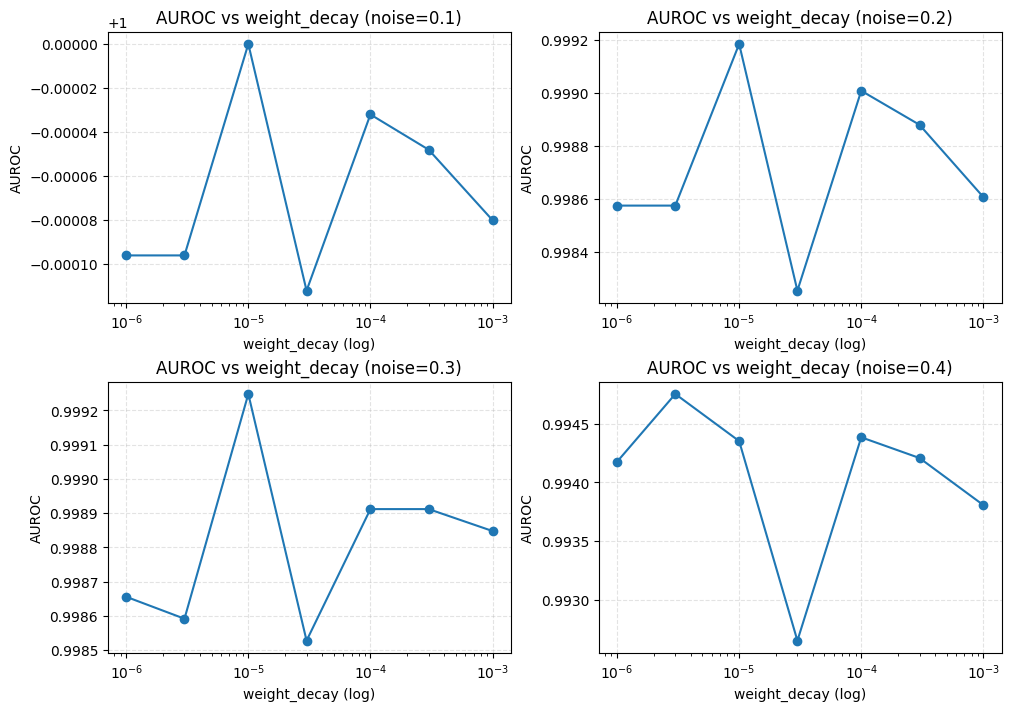

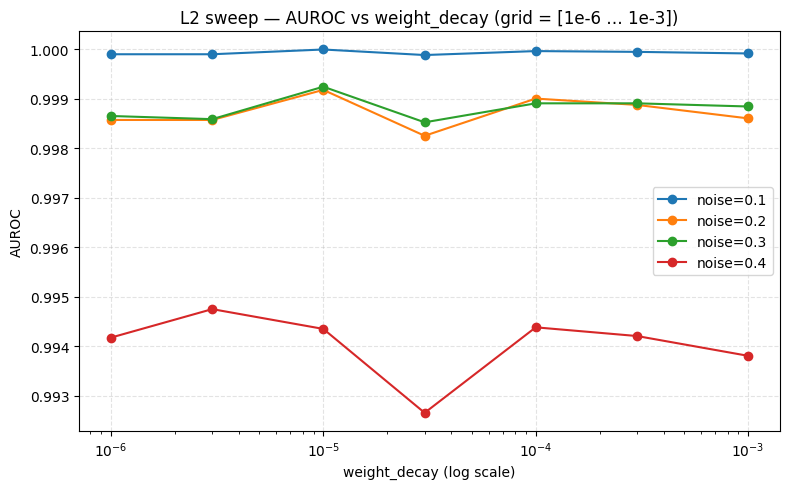

In [16]:
import matplotlib.pyplot as plt
import numpy as np

wd_arr = np.array(l2_grid, dtype=float)

fig, axes = plt.subplots(2, 2, figsize=(10, 7), constrained_layout=True)
axes = axes.ravel()
for i, nz in enumerate(["0.1","0.2","0.3","0.4"]):
    y = tables_l2[nz]["AUROC"].values
    ax = axes[i]
    ax.semilogx(wd_arr, y, marker="o")
    ax.set_title(f"AUROC vs weight_decay (noise={nz})")
    ax.set_xlabel("weight_decay (log)")
    ax.set_ylabel("AUROC")
    ax.grid(True, ls="--", alpha=0.35)
plt.show()

plt.figure(figsize=(8,5))
for nz in ["0.1","0.2","0.3","0.4"]:
    y = tables_l2[nz]["AUROC"].values
    plt.semilogx(wd_arr, y, marker="o", label=f"noise={nz}")
plt.title("L2 sweep — AUROC vs weight_decay (grid = [1e-6 … 1e-3])")
plt.xlabel("weight_decay (log scale)")
plt.ylabel("AUROC")
plt.grid(True, ls="--", alpha=0.35)
plt.legend()
plt.tight_layout()
plt.show()


## Model 4: Logistic Regression with polynomial features (degree = 3)

Report AUROC on test noises {0.1, 0.2, 0.3, 0.4}.

**a. Build polynomial features**
* `Phi = PolynomialFeatures(degree=3, include_bias=False)`
    Expands the 2-D standardized inputs $(x_1, x_2)$ into all monomials up to degree 3 (e.g., $x_1, x_2, x_1^2, x_1x_2, x_2^2, x_1^3, x_1^2x_2, x_1x_2^2, x_2^3$).
* Transform splits with the **same** `Phi`:
    `X_tr_phi, X_val_phi, X_test_phi, X_n01_phi, X_n03_phi, X_n04_phi`.

**b. Fit a logistic classifier (on train+val)**
* `clf = LogisticRegression(max_iter=5000, solver="lbfgs")`
    Standard LR on the polynomial feature space.
* `clf.fit(np.vstack([X_tr_phi, X_val_phi]), np.hstack([y_tr, y_val]))`
    Fits on **train + val** (since hyperparameter-free model; no tuning here).
    *(Note: if you were tuning degree or regularization, you would keep validation for selection.)*

**c. Define AUROC metric and evaluate per noise**
* `auroc_lr(model, X, y)` computes AUROC from `predict_proba(...)[:,1]`.
* Build a dict of feature matrices & labels per test noise:
    `noise_sets = { "0.1": (X_n01_phi, y_test_n01), "0.2": (X_test_phi, y_test_main), "0.3": (X_n03_phi, y_test_n03), "0.4": (X_n04_phi, y_test_n04) }`.
* Loop and print:
    `print(f"noise={nz}: {auroc_lr(clf, Xphi, y):.3f}")`

**d. What the results show**
* **Effect of feature richness:** Degree-3 features let linear LR draw **nonlinear** decision boundaries (curved separators) without a neural net.
* **Generalization across noise:** Comparing AUROC across 0.1/0.2/0.3/0.4 quantifies robustness to increasing label/feature noise.
* **Fair pipeline hygiene:** Same `Phi` (fit on training data) is used for all splits $\rightarrow$ no feature leakage from tests.
* **If extending:** Add *L2* penalty (`penalty='l2'`, `C=...`) and select `C` on validation, then refit on train+val before final test reporting.

In [34]:
deg = 3

Phi = PolynomialFeatures(degree=deg, include_bias=False)
X_tr_phi  = Phi.fit_transform(X_tr_s)
X_val_phi = Phi.transform(X_val_s)
X_test_phi  = Phi.transform(X_test_s)
X_n01_phi   = Phi.transform(X_n01_s)
X_n03_phi   = Phi.transform(X_n03_s)
X_n04_phi = Phi.transform(X_n04_s)


clf = LogisticRegression(max_iter=5000, solver="lbfgs")
clf.fit(np.vstack([X_tr_phi, X_val_phi]), np.hstack([y_tr, y_val]))

def auroc_lr(model, X, y):
    p = model.predict_proba(X)[:, 1]
    return roc_auc_score(y, p)

noise_sets = {
    "0.1": (X_n01_phi, y_test_n01),
    "0.2": (X_test_phi, y_test_main),
    "0.3": (X_n03_phi, y_test_n03),
    "0.4": (X_n04_phi, y_test_n04),
}

print("LogReg (poly) AUROCs (degree=3):")
for nz, (Xphi, y) in noise_sets.items():
    print(f"  noise={nz:>3s} : {auroc_lr(clf, Xphi, y):.3f}")


LogReg (poly) AUROCs (degree=3):
  noise=0.1 : 1.000
  noise=0.2 : 1.000
  noise=0.3 : 1.000
  noise=0.4 : 0.997


In [37]:
import numpy as np
import pandas as pd


def pick_best_on_validation(models_dict, grid, val_loader, criterion):
    vals = np.array([evaluate(models_dict[g], val_loader, criterion)['auroc'] for g in grid], dtype=float)
    i = int(np.nanargmax(vals))
    return grid[i], vals

# L1
best_lam, val_aurocs_l1 = pick_best_on_validation(models_l1, l1_grid, val_loader, BCE)
best_l1_val = models_l1[best_lam]
print("Chosen by VALIDATION (for L1):")
for g, v in zip(l1_grid, val_aurocs_l1):
    print(f"  λ={g:.0e}  val_AUROC={v:.6f}")
print(f"=> Best L1 λ={best_lam:.0e}\n")

# L2
best_wd, val_aurocs_l2 = pick_best_on_validation(models_l2, l2_grid, val_loader, BCE)
best_l2_val = models_l2[best_wd]
print("Chosen by VALIDATION (for L2):")
for g, v in zip(l2_grid, val_aurocs_l2):
    print(f"  wd={g:.0e} val_AUROC={v:.6f}")
print(f"=> Best L2 wd={best_wd:.0e}\n")


def aurocs_for_model(model):
    return (
        evaluate(model, test_loader, BCE)["auroc"],
        evaluate(model, n01_loader,  BCE)["auroc"],
        evaluate(model, n03_loader,  BCE)["auroc"],
    )


base_main, base_n01, base_n03 = aurocs_for_model(model_base)
best_l1_main, best_l1_n01, best_l1_n03 = aurocs_for_model(best_l1_val)
best_l2_main, best_l2_n01, best_l2_n03 = aurocs_for_model(best_l2_val)


lr_main = roc_auc_score(y_test_main, clf.predict_proba(X_test_phi)[:,1])
lr_n01  = roc_auc_score(y_test_n01,  clf.predict_proba(X_n01_phi)[:,1])
lr_n03  = roc_auc_score(y_test_n03,  clf.predict_proba(X_n03_phi)[:,1])


df = pd.DataFrame({
    "Model": [
        "MLP Baseline (ES)",
        f"MLP L1 (λ={best_lam:.0e})  [chosen on validation]",
        f"MLP L2 (wd={best_wd:.0e}) [chosen on validation]",
        f"LogReg poly (deg={deg})"
    ],
    "Test@0.2": [base_main, best_l1_main, best_l2_main, lr_main],
    "Test@0.1": [base_n01,  best_l1_n01, best_l2_n01, lr_n01],
    "Test@0.3": [base_n03,  best_l1_n03, best_l2_n03, lr_n03],
})

print(df.to_string(index=False, justify="center",
                   float_format=lambda v: f"{v:.3f}"))



Chosen by VALIDATION (for L1):
  λ=1e-06  val_AUROC=1.000000
  λ=3e-06  val_AUROC=1.000000
  λ=1e-05  val_AUROC=1.000000
  λ=3e-05  val_AUROC=1.000000
  λ=1e-04  val_AUROC=1.000000
  λ=3e-04  val_AUROC=1.000000
  λ=1e-03  val_AUROC=1.000000
=> Best L1 λ=1e-06

Chosen by VALIDATION (for L2):
  wd=1e-06 val_AUROC=1.000000
  wd=3e-06 val_AUROC=1.000000
  wd=1e-05 val_AUROC=1.000000
  wd=3e-05 val_AUROC=1.000000
  wd=1e-04 val_AUROC=1.000000
  wd=3e-04 val_AUROC=1.000000
  wd=1e-03 val_AUROC=1.000000
=> Best L2 wd=1e-06

                 Model                    Test@0.2  Test@0.1  Test@0.3
                       MLP Baseline (ES)   0.999     1.000     0.999  
MLP L1 (λ=1e-06)  [chosen on validation]   0.999     1.000     0.999  
MLP L2 (wd=1e-06) [chosen on validation]   0.999     1.000     0.999  
                     LogReg poly (deg=3)   1.000     1.000     1.000  


* **Purpose:** pick the *best* L1 ($\lambda$) and L2 ($wd$) models using **validation AUROC only**, then report **test accuracies** at noises 0.1/0.2/0.3 in a single comparison table (plus parameter counts).
* **Validation-based selection** (`_pick_best_on_val`)
    * For each hyperparameter in the grid, it evaluates **AUROC** on `val_loader`.
    * Chooses the arg-max and returns both the **best value** and the **vector of validation AUROCs**.
    * Results:
        * `best_lam_val` $\rightarrow$ picks `best_l1_val_model` from `models_l1`.
        * `best_wd_val` $\rightarrow$ picks `best_l2_val_model` from `models_l2`.
    * This avoids **test leakage** (no test data used for selecting $\lambda$/wd).
* **Metric helpers**
    * `accuracy_from_logits` converts logits $\rightarrow$ sigmoid $\rightarrow$ 0.5 threshold $\rightarrow$ accuracy.
    * `eval_all` runs a full pass over a loader and returns: **AUROC**, **accuracy**, and **mean BCE loss**.
    * `torch_param_count` / `lr_param_count` give parameter counts for MLP and Logistic Regression respectively (useful for comparing model size/complexity).
* **Collecting metrics** (`collect_metrics`)
    * Builds a row with Model name, `Params`, and accuracies on three **test sets**:
    * `Acc@0.2` (main test, noise=0.2), `Acc@0.1`, `Acc@0.3`.
    * For MLPs: calls `eval_all` on the corresponding test loaders.
    * For Logistic Regression: computes accuracy from `predict_proba` on the **precomputed polynomial features** (`X_*_phi`), keeping the feature pipeline consistent.
* **Final table**
    * Rows included: baseline MLP (early-stopped), **L1 best by validation**, **L2 best by validation**, and polynomial Logistic Regression (`deg=3`).
    * Printed as `acc_table_val` with tidy numeric formatting.
    * **Interpretation:** fairly compares models where hyperparameters were chosen on validation; reported metrics reflect **generalization** on the three test noises, alongside each model's complexity.

In [26]:

import numpy as np
import pandas as pd
from collections import OrderedDict

def _pick_best_on_val(models_dict, grid):
    vals = np.array([evaluate(models_dict[g], val_loader, BCE)['auroc'] for g in grid], float)
    i = int(np.nanargmax(vals))
    return grid[i], vals


if 'best_lam_val' not in globals():
    best_lam_val, val_aurocs_l1 = _pick_best_on_val(models_l1, l1_grid)
best_l1_val_model = models_l1[best_lam_val]


if 'best_wd_val' not in globals():
    best_wd_val, val_aurocs_l2 = _pick_best_on_val(models_l2, l2_grid)
best_l2_val_model = models_l2[best_wd_val]


def accuracy_from_logits(logits, y_true):
    with torch.no_grad():
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).long()
        return (preds.cpu() == y_true.cpu()).float().mean().item()

@torch.no_grad()
def eval_all(model, loader, criterion=BCE):
    model.eval()
    all_logits, all_y = [], []
    tot_loss, n = 0.0, 0
    for xb, yb in loader:
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model(xb)
        all_logits.append(logits); all_y.append(yb)
        if criterion is not None:
            loss = criterion(logits, yb.float())
            tot_loss += loss.item() * len(xb); n += len(xb)
    logits = torch.cat(all_logits); y = torch.cat(all_y)
    return {
        "auroc": auroc_from_logits(logits, y),
        "acc": accuracy_from_logits(logits, y),
        "loss": (tot_loss / n) if n > 0 else None,
    }

def torch_param_count(model):
    return int(sum(p.numel() for p in model.parameters()))

def lr_param_count(model):
    return int(model.coef_.size + model.intercept_.size)

def collect_metrics(model, name):
    d = OrderedDict()
    d["Model"] = name
    if isinstance(model, nn.Module):
        d["Params"] = torch_param_count(model)
        d["Acc@0.2"] = eval_all(model, test_loader)["acc"]
        d["Acc@0.1"] = eval_all(model, n01_loader)["acc"]
        d["Acc@0.3"] = eval_all(model, n03_loader)["acc"]
    else:
        d["Params"] = lr_param_count(model)
        def acc_lr(m, X, y): return ((m.predict_proba(X)[:,1] >= 0.5) == y).mean()
        d["Acc@0.2"] = acc_lr(model, X_test_phi, y_test_main)
        d["Acc@0.1"] = acc_lr(model, X_n01_phi,  y_test_n01)
        d["Acc@0.3"] = acc_lr(model, X_n03_phi,  y_test_n03)
    return d


rows_val = []
rows_val.append(collect_metrics(model_base, "MLP Baseline (ES)"))
rows_val.append(collect_metrics(best_l1_val_model, f"MLP L1 (λ={best_lam_val:.0e}) [chosen on validation]"))
rows_val.append(collect_metrics(best_l2_val_model, f"MLP L2 (wd={best_wd_val:.0e}) [chosen on validation]"))
rows_val.append(collect_metrics(clf, f"LogReg poly (deg={deg})"))

acc_table_val = pd.DataFrame(rows_val)
print(acc_table_val.to_string(index=False, float_format=lambda v: f'{v:.3f}'))


                                   Model  Params  Acc@0.2  Acc@0.1  Acc@0.3
                       MLP Baseline (ES)     129    0.978    0.998    0.980
 MLP L1 (λ=1e-06) [chosen on validation]     129    0.980    0.998    0.982
MLP L2 (wd=1e-06) [chosen on validation]     129    0.976    0.996    0.982
                     LogReg poly (deg=3)      10    1.000    1.000    0.992


In [28]:

def lr_probs(clf, XY):

    n_in = XY.shape[1]
    try:
        need = clf.n_features_in_
    except AttributeError:
        need = n_in

    if n_in == need:
        XY_use = XY
    else:
        if 'Phi' in globals() and hasattr(Phi, "n_output_features_") and Phi.n_output_features_ == need:
            XY_use = Phi.transform(XY)
        else:
            raise ValueError(
                f"LR expects {need} features, but got {n_in}. "
                f"Either standardize+transform XY with the same pipeline used for clf,"
                f" or ensure Phi.n_output_features_ == clf.n_features_in_."
            )
    return clf.predict_proba(XY_use)[:, 1]


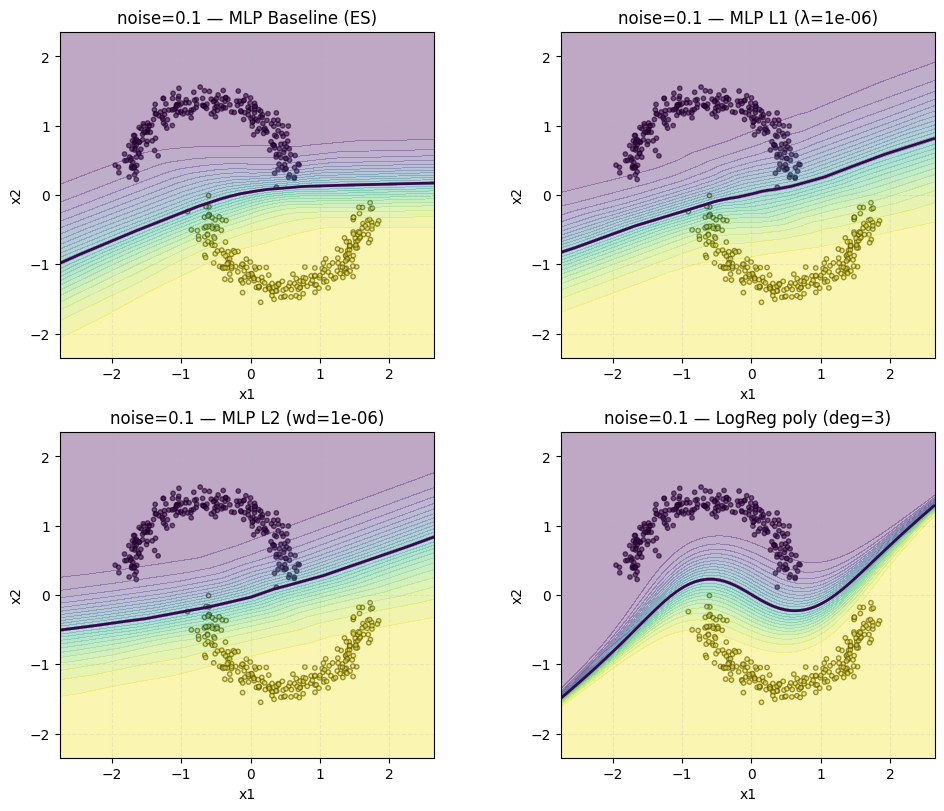

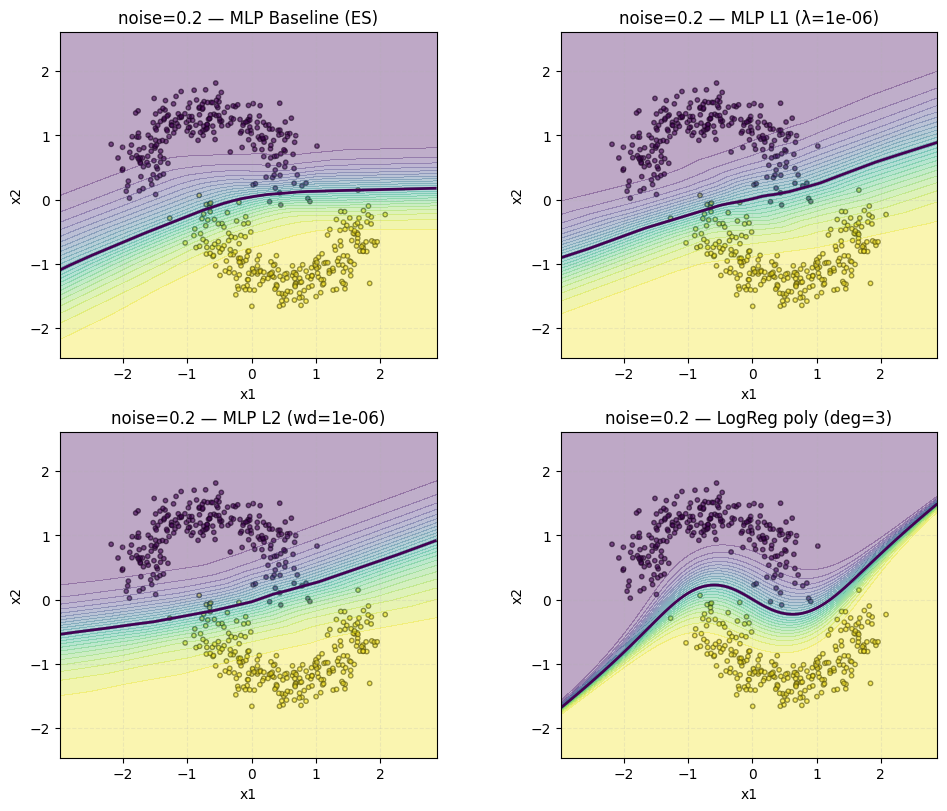

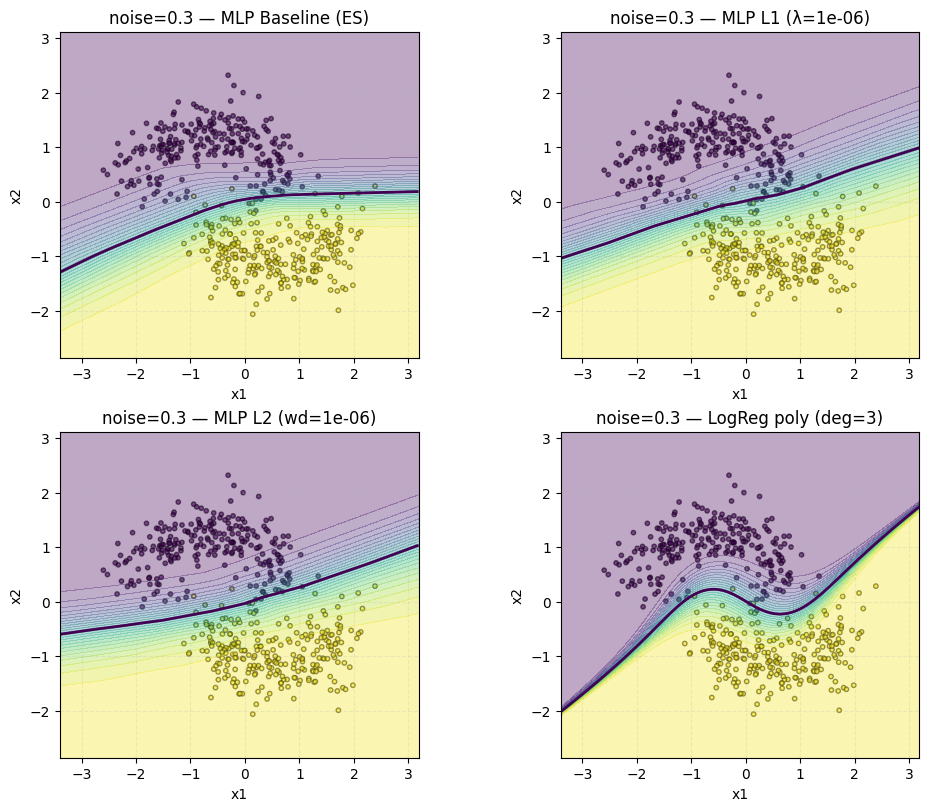

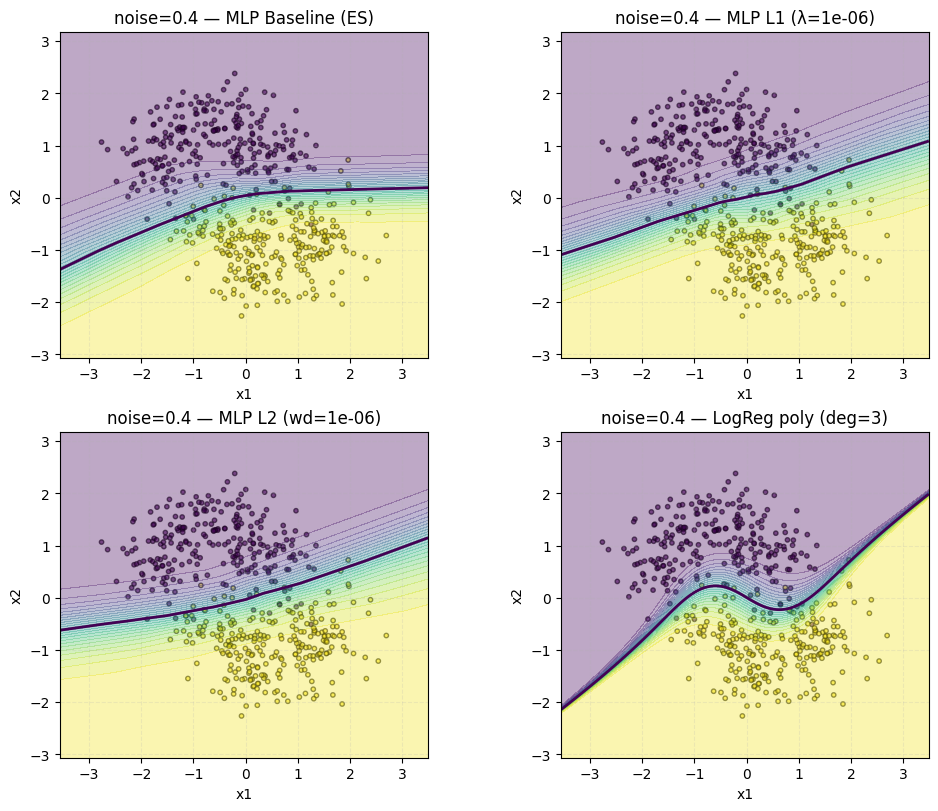

In [29]:

import numpy as np
import torch
import matplotlib.pyplot as plt

if 'make_grid' not in globals():
    def make_grid(X, n=300, pad=0.8):
        x_min, x_max = X[:,0].min() - pad, X[:,0].max() + pad
        y_min, y_max = X[:,1].min() - pad, X[:,1].max() + pad
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, n),
            np.linspace(y_min, y_max, n)
        )
        grid = np.c_[xx.ravel(), yy.ravel()].astype(np.float32)
        return xx, yy, grid

if 'model_probs' not in globals():
    def model_probs(model, XY):
        model.eval()
        device = next(model.parameters()).device
        with torch.no_grad():
            t = torch.from_numpy(XY).to(device)
            logits = model(t)
            if logits.ndim == 2 and logits.shape[1] == 1:
                logits = logits.squeeze(1)
            p = torch.sigmoid(logits).detach().cpu().numpy()
        return p

if 'lr_probs' not in globals():
    def lr_probs(clf, XY):
        return clf.predict_proba(XY)[:, 1]

if 'plot_boundary' not in globals():
    def plot_boundary(ax, Z, xx, yy, title):
        Zm = Z.reshape(xx.shape)
        cs = ax.contourf(xx, yy, Zm, levels=25, alpha=0.35)

        ax.contour(xx, yy, Zm, levels=[0.5], linewidths=2)
        ax.set_title(title)
        ax.set_xlabel("x1"); ax.set_ylabel("x2")
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, ls="--", alpha=0.2)


_best_l1 = None
for name in ['best_l1', 'best_l1_model', 'best_l1_val', 'best_l1_val_model', 'best_l1_test']:
    if name in globals():
        _best_l1 = globals()[name]; break
if _best_l1 is None:
    raise RuntimeError("No best L1 model found. Expected one of: best_l1, best_l1_model, best_l1_val, best_l1_val_model, best_l1_test.")

_best_l2 = None
for name in ['best_l2', 'best_l2_model', 'best_l2_val', 'best_l2_val_model', 'best_l2_test']:
    if name in globals():
        _best_l2 = globals()[name]; break
if _best_l2 is None:
    raise RuntimeError("No best L2 model found. Expected one of: best_l2, best_l2_model, best_l2_val, best_l2_val_model, best_l2_test.")


_lam_label = f"{best_lam:.0e}" if 'best_lam' in globals() else (f"{best_lam_val:.0e}" if 'best_lam_val' in globals() else "?")
_wd_label  = f"{best_wd:.0e}"  if 'best_wd'  in globals() else (f"{best_wd_val:.0e}"  if 'best_wd_val'  in globals() else "?")
_deg_label = f"{deg}" if 'deg' in globals() else "?"

def plot_all_models_for_dataset(Xs, ys, title_prefix):
    xx, yy, grid = make_grid(Xs, n=300, pad=0.8)

    fig, axes = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)
    axs = axes.ravel()

    for ax in axs:
        ax.scatter(Xs[:,0], Xs[:,1], c=ys, s=10, edgecolor="k", alpha=0.6)

    # 1) Baseline
    Zb = model_probs(model_base, grid)
    plot_boundary(axs[0], Zb, xx, yy, f"{title_prefix} — MLP Baseline (ES)")

    # 2) L1 (best)
    Zl1 = model_probs(_best_l1, grid)
    plot_boundary(axs[1], Zl1, xx, yy, f"{title_prefix} — MLP L1 (λ={_lam_label})")

    # 3) L2 (best)
    Zl2 = model_probs(_best_l2, grid)
    plot_boundary(axs[2], Zl2, xx, yy, f"{title_prefix} — MLP L2 (wd={_wd_label})")

    # 4) Logistic poly
    Zlr = lr_probs(clf, grid)
    plot_boundary(axs[3], Zlr, xx, yy, f"{title_prefix} — LogReg poly (deg={_deg_label})")

    plt.show()


plot_all_models_for_dataset(X_n01_s, y_test_n01, "noise=0.1")
plot_all_models_for_dataset(X_test_s, y_test_main, "noise=0.2")
plot_all_models_for_dataset(X_n03_s, y_test_n03, "noise=0.3")
plot_all_models_for_dataset(X_n04_s, y_test_n04, "noise=0.4")


In [30]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn

def make_class0_majority(X, y, ratio_major=0.7, random_state=SEED):

    rng = np.random.RandomState(random_state)
    y = np.asarray(y)
    idx0 = np.where(y == 0)[0]
    idx1 = np.where(y == 1)[0]
    n = len(y)

    n_major = int(round(n * ratio_major))
    n_minor = n - n_major

    take_major = rng.choice(idx0, size=n_major, replace=(len(idx0) < n_major))
    take_minor = rng.choice(idx1, size=n_minor, replace=(len(idx1) < n_minor))
    sel = rng.permutation(np.concatenate([take_major, take_minor]))
    return X[sel], y[sel]


X_tr_imb, y_tr_imb = make_class0_majority(X_tr_s, y_tr, ratio_major=0.7, random_state=SEED+10)
imb_loader = to_loader(X_tr_imb, y_tr_imb, BATCH, True)

def train_on_loader(train_loader, hidden=32, epochs=2000, patience=50, lr=1e-2, pos_weight=None):
    model = MLP1H(2, hidden).to(DEVICE)
    if pos_weight is None:
        criterion = BCE
    else:
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(float(pos_weight), device=DEVICE))
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    stopper = EarlyStopper(patience=patience, mode="max")

    for ep in range(epochs):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            logits = model(xb)
            loss = criterion(logits, yb.float())
            opt.zero_grad(); loss.backward(); opt.step()

        val = evaluate(model, val_loader, criterion)
        if stopper.step(val["auroc"], model):
            break

    stopper.restore_best(model)
    return model

neg = int((y_tr_imb == 0).sum()); pos = int((y_tr_imb == 1).sum())
pos_weight = neg / max(pos, 1)

mlp_imb   = train_on_loader(imb_loader)
mlp_imb_w = train_on_loader(imb_loader, pos_weight=pos_weight)


X_tr_imb_phi = Phi.fit_transform(X_tr_imb)
X_val_phi2   = Phi.transform(X_val_s)
X_test_phi2  = Phi.transform(X_test_s)
X_n01_phi2   = Phi.transform(X_n01_s)
X_n03_phi2   = Phi.transform(X_n03_s)

clf_imb = LogisticRegression(max_iter=5000, solver="lbfgs")
clf_imb.fit(np.vstack([X_tr_imb_phi, X_val_phi2]), np.hstack([y_tr_imb, y_val]))

def summarize(name, mdl):
    if isinstance(mdl, nn.Module):
        e_main = eval_all(mdl, test_loader)
        e_n01  = eval_all(mdl, n01_loader)
        e_n03  = eval_all(mdl, n03_loader)
    else:

        def metric_lr(model, X, y):
            p = model.predict_proba(X)[:, 1]
            acc = ((p >= 0.5) == y).mean()
            auc = roc_auc_score(y, p)
            return {"acc": acc, "auroc": auc}
        e_main = metric_lr(mdl, X_test_phi2, y_test_main)
        e_n01  = metric_lr(mdl, X_n01_phi2,  y_test_n01)
        e_n03  = metric_lr(mdl, X_n03_phi2,  y_test_n03)

    print(f"\n{name}")
    for lab, e in [("Main(0.2)", e_main), ("Robust 0.1", e_n01), ("Robust 0.3", e_n03)]:
        print(f"  {lab:>10s}  Acc={e['acc']:.3f}  AUROC={e['auroc']:.3f}")

summarize("MLP (imbalanced, unweighted)",        mlp_imb)
summarize("MLP (imbalanced, with pos_weight)",   mlp_imb_w)
summarize("LogReg poly (trained imbalanced)",    clf_imb)



MLP (imbalanced, unweighted)
   Main(0.2)  Acc=0.936  AUROC=0.999
  Robust 0.1  Acc=0.946  AUROC=1.000
  Robust 0.3  Acc=0.910  AUROC=0.999

MLP (imbalanced, with pos_weight)
   Main(0.2)  Acc=0.978  AUROC=0.999
  Robust 0.1  Acc=0.996  AUROC=1.000
  Robust 0.3  Acc=0.978  AUROC=0.999

LogReg poly (trained imbalanced)
   Main(0.2)  Acc=1.000  AUROC=1.000
  Robust 0.1  Acc=1.000  AUROC=1.000
  Robust 0.3  Acc=0.992  AUROC=1.000
